In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from torchvision import transforms
from torchvision.models import efficientnet_b0
import PIL.Image as Image
from torch.cuda.amp import GradScaler, autocast
from google.colab import drive
import os
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab Notebooks'

class FERDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        file_path = os.path.join(data_dir, csv_file)
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = [int(pixel) for pixel in self.data.iloc[idx]['pixels'].split()]
        image = np.array(pixels).reshape(48, 48).astype(np.uint8)
        image = Image.fromarray(image).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = int(self.data.iloc[idx]['emotion'])
        return image, label

def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    return train_transform, test_transform


Mounted at /content/drive


In [ ]:
def create_data_loaders(train_transform, test_transform, batch_size=32):
    train_path = os.path.join(data_dir, 'train.csv')
    test_path = os.path.join(data_dir, 'test.csv')
    train_dataset = FERDataset(train_path, transform=train_transform)
    test_dataset = FERDataset(test_path, transform=test_transform)

    # Set num_workers=0 for compatibility in Jupyter notebooks
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

    return train_loader, test_loader

# Initialize transforms and data loaders
train_transform, test_transform = get_transforms()
train_loader, test_loader = create_data_loaders(train_transform, test_transform)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def train_model(train_loader, test_loader, device):
    print("Initializing EfficientNet model...")
    model = efficientnet_b0(weights='IMAGENET1K_V1')
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_ftrs, 7)  # 7 classes for FER
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
    scaler = GradScaler()

    num_epochs = 20
    best_accuracy = 0

    print("Starting training...")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():  # Mixed precision training
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] '
                      f'Loss: {loss.item():.4f}')

        train_accuracy = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_accuracy = 100. * correct / total
        avg_val_loss = val_loss / len(test_loader)

        scheduler.step(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}] Summary:')
        print(f'Training Loss: {running_loss/len(train_loader):.4f}')
        print(f'Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_accuracy': best_accuracy,
            }, 'best_model.pth')
            print(f'New best model saved with accuracy: {best_accuracy:.2f}%')

        print('-' * 60)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model(train_loader, test_loader, device)


Initializing EfficientNet model...


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 167MB/s]
<ipython-input-2-89037ab7c609>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-2-89037ab7c609>:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision training


Starting training...
Epoch [1/20] Batch [0/898] Loss: 2.0235
Epoch [1/20] Batch [100/898] Loss: 1.5154
Epoch [1/20] Batch [200/898] Loss: 1.1412
Epoch [1/20] Batch [300/898] Loss: 1.0584
Epoch [1/20] Batch [400/898] Loss: 1.3656
Epoch [1/20] Batch [500/898] Loss: 1.6980
Epoch [1/20] Batch [600/898] Loss: 1.1499
Epoch [1/20] Batch [700/898] Loss: 1.4672
Epoch [1/20] Batch [800/898] Loss: 0.8857


<ipython-input-2-89037ab7c609>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/20] Summary:
Training Loss: 1.1859
Training Accuracy: 55.45%
Validation Accuracy: 59.82%
New best model saved with accuracy: 59.82%
------------------------------------------------------------
Epoch [2/20] Batch [0/898] Loss: 0.9784
Epoch [2/20] Batch [100/898] Loss: 1.0476
Epoch [2/20] Batch [200/898] Loss: 0.9485
Epoch [2/20] Batch [300/898] Loss: 1.0199
Epoch [2/20] Batch [400/898] Loss: 0.7225
Epoch [2/20] Batch [500/898] Loss: 0.9591
Epoch [2/20] Batch [600/898] Loss: 0.9305
Epoch [2/20] Batch [700/898] Loss: 0.9293
Epoch [2/20] Batch [800/898] Loss: 0.6187
Epoch [2/20] Summary:
Training Loss: 1.0056
Training Accuracy: 62.31%
Validation Accuracy: 62.64%
New best model saved with accuracy: 62.64%
------------------------------------------------------------
Epoch [3/20] Batch [0/898] Loss: 0.8767
Epoch [3/20] Batch [100/898] Loss: 0.5797
Epoch [3/20] Batch [200/898] Loss: 0.8173
Epoch [3/20] Batch [300/898] Loss: 0.8709
Epoch [3/20] Batch [400/898] Loss: 1.1482
Epoch [3/20]

In [ ]:
model = efficientnet_b0()
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 7)
model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
model = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
torch.save(model.state_dict(), 'best_model_quantized.pth')
print("Quantized model saved for inference.")


<ipython-input-7-9a50c34c75fc>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])


Quantized model saved for inference.


<ipython-input-26-1ddbcdb85e21>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])


              precision    recall  f1-score   support

       anger       0.61      0.64      0.62       467
     disgust       0.83      0.68      0.75        56
        fear       0.61      0.52      0.57       496
   happiness       0.88      0.87      0.88       895
     sadness       0.61      0.59      0.60       653
    surprise       0.80      0.85      0.82       415
     neutral       0.60      0.66      0.63       607

    accuracy                           0.70      3589
   macro avg       0.71      0.69      0.69      3589
weighted avg       0.70      0.70      0.70      3589



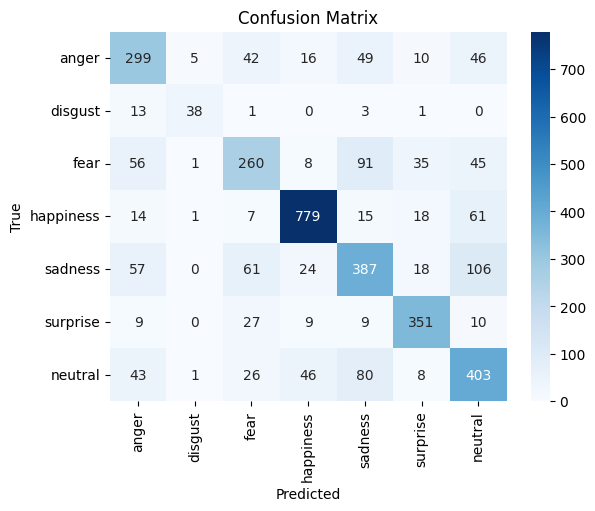

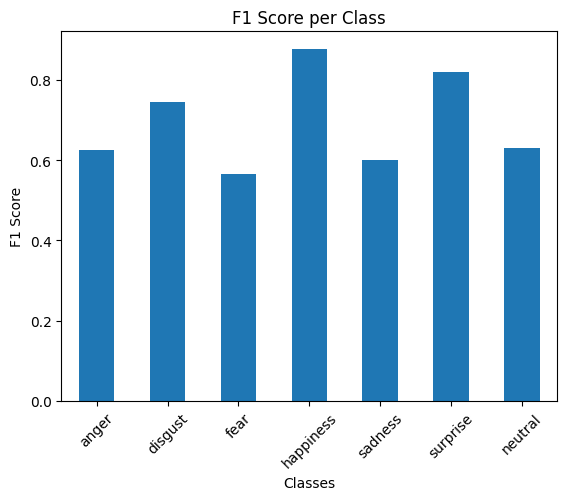

In [ ]:
# Assuming the necessary imports like torch, nn, and DataLoader are already done
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Define the emotion labels
EMOTIONS = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

# Load the model architecture
model = efficientnet_b0()
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 7)

# Load the saved model state dict
model.load_state_dict(torch.load('best_model.pth')['model_state_dict'])
model.eval()

# Assume you have a DataLoader for the test set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Classification Report
print(classification_report(y_true, y_pred, target_names=[EMOTIONS[i] for i in range(7)]))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[EMOTIONS[i] for i in range(7)], yticklabels=[EMOTIONS[i] for i in range(7)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plotting F1-score for each class
report = classification_report(y_true, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df['f1-score'][:-3].plot(kind='bar', title='F1 Score per Class', xticks=range(7), rot=45)
plt.xlabel('Classes')
plt.ylabel('F1 Score')
plt.xticks(ticks=range(7), labels=[EMOTIONS[i] for i in range(7)])
plt.show()

# Visualize a few test samples with predictions
data_iter = iter(test_loader)
images, labels = next(data_iter)

images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = outputs.max(1)




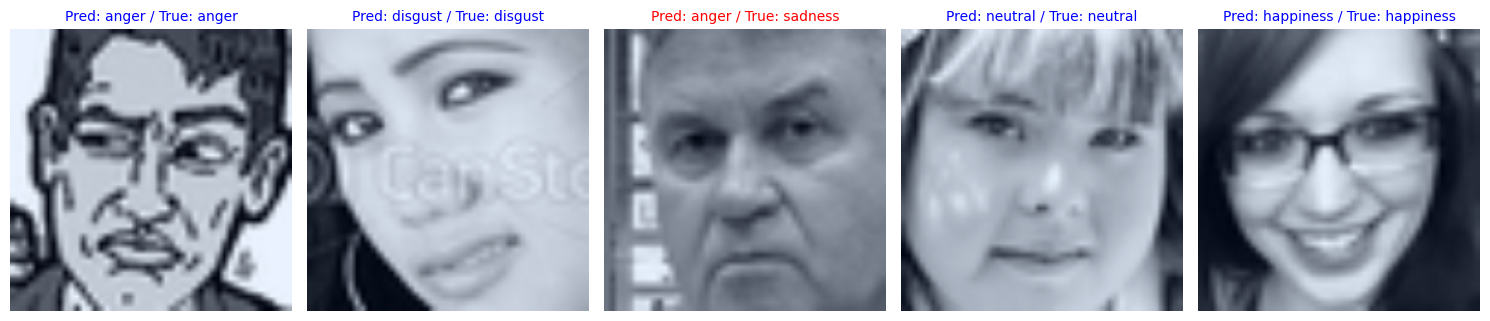

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for idx in range(5):
    ax = axes[idx]
    image = images[idx].cpu().permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())  # Normalize the image for better visualization
    if image.shape[2] == 1:  # If grayscale image with a single channel
        ax.imshow(image.squeeze(), cmap='gray')
    else:  # If RGB image
        ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'Pred: {EMOTIONS[preds[idx].item()]} / True: {EMOTIONS[labels[idx].item()]}', fontsize=10, color='blue' if preds[idx] == labels[idx] else 'red')
plt.tight_layout()
plt.show()

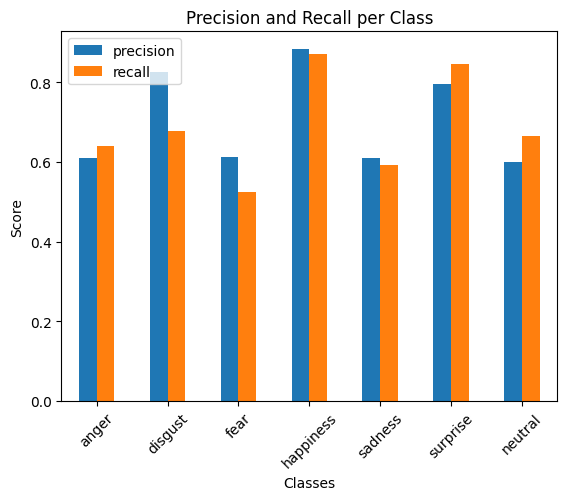

In [ ]:
report_df[['precision', 'recall']][:-3].plot(kind='bar', title='Precision and Recall per Class', rot=45)
plt.xlabel('Classes')
plt.ylabel('Score')
plt.xticks(ticks=range(7), labels=[EMOTIONS[i] for i in range(7)])
plt.show()

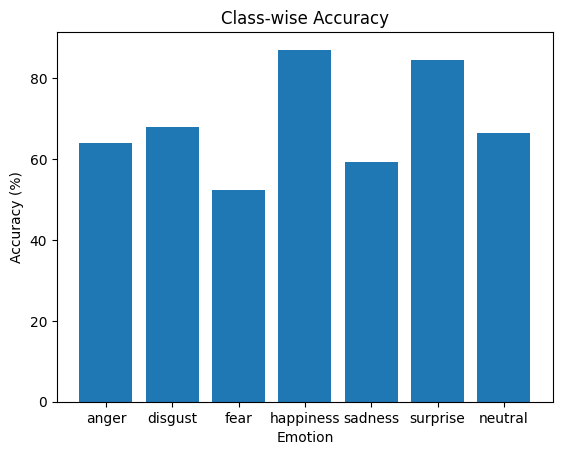

In [ ]:
class_correct = {i: 0 for i in range(7)}
class_total = {i: 0 for i in range(7)}

for i in range(len(y_true)):
    label = y_true[i]
    if y_true[i] == y_pred[i]:
        class_correct[label] += 1
    class_total[label] += 1

class_accuracy = {i: 100 * class_correct[i] / class_total[i] for i in range(7)}

plt.bar([EMOTIONS[i] for i in range(7)], class_accuracy.values())
plt.xlabel('Emotion')
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Accuracy')
plt.show()
